## Get data from Yahoo

https://es.finance.yahoo.com/

Buscamos un ticker, por ejemplo Cisco (CSCO)

<center>
<img src="imgs/yf_cisco.png"  alt="drawing" width="50%"/>
</center>

https://finance.yahoo.com/quote/CSCO/options?p=CSCO

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import datetime
import mibian

import warnings
warnings.filterwarnings("ignore")

In [8]:
msft = yf.Ticker("MSFT")
csco = yf.Ticker("CSCO")

# get historical market data
msft_hist = msft.history(period="max")
csco_hist = csco.history(period="max")

csco_hist= csco_hist[csco_hist.index > '2020-01-01']

Elijo una fecha de vencimiento entre las disponibles

In [9]:
# show options expirations
exp_dates = csco.options
print(' Las fechas de vencimiento disponibles son : ', exp_dates)

#elijo, por ejemplo, la fecha de la que está en el noveno lugar
vcto_str = exp_dates[9] 
print('\n La fecha de vencimiento elegida es : ', vcto_str)

 Las fechas de vencimiento disponibles son :  ('2022-08-26', '2022-09-02', '2022-09-09', '2022-09-16', '2022-09-23', '2022-09-30', '2022-10-21', '2022-12-16', '2023-01-20', '2023-03-17', '2023-04-21', '2023-06-16', '2024-01-19', '2024-06-21')

 La fecha de vencimiento elegida es :  2023-03-17


Elijo todas las opciones con  fecha de vencimiento igual a la elegida

In [10]:
# get option chain for specific expiration
csco_opt = csco.option_chain(vcto_str)  

# data available via: opt.calls, opt.puts
csco_opt_calls = csco_opt.calls.loc[:, ['lastTradeDate', 'strike', 'lastPrice']]

#convert lastTradeDate to date format
csco_opt_calls.lastTradeDate = csco_opt_calls.lastTradeDate.apply(lambda x: x.date())



csco_opt_calls

,lastTradeDate,strike,lastPrice
0,2022-07-18,27.5,16.15
1,2022-08-16,30.0,17.34
2,2022-08-02,32.5,13.68
3,2022-08-04,35.0,11.55
4,2022-08-10,37.5,9.85
5,2022-08-19,40.0,10.05
6,2022-08-19,42.5,8.35
7,2022-08-19,45.0,6.25
8,2022-08-19,47.5,4.65
9,2022-08-19,50.0,3.45


Selecciono aquellas que se negociaron en una fecha determinada

In [11]:
# elijo, por ejemplo, la que está en el séptimo lugar
posicion=7
trade_date = csco_opt_calls.iloc[posicion]['lastTradeDate']
csco_opt_calls = csco_opt_calls[csco_opt_calls['lastTradeDate'] == trade_date]
csco_opt_calls

,lastTradeDate,strike,lastPrice
5,2022-08-19,40.0,10.05
6,2022-08-19,42.5,8.35
7,2022-08-19,45.0,6.25
8,2022-08-19,47.5,4.65
9,2022-08-19,50.0,3.45
10,2022-08-19,52.5,2.35
11,2022-08-19,55.0,1.50
12,2022-08-19,60.0,0.59


Elegimos la primera, obtenemos todos los datos
- S:            Valor del activo subyacente
- K:            Valor de strike de la opción
- T:            Tiempo hasta vencimiento (en % de años)
- market_price: Valor de la opción en el mercado

 y, usando una librería de python (mibiam) calculamos la volatilidad implícita

Calculamos los parámetros comunes a todas las opciones

In [12]:
vcto = datetime.datetime.strptime(vcto_str, '%Y-%m-%d')
T = ((vcto.date()-trade_date).days)/365
S0 = csco_hist.loc[trade_date.strftime('%Y-%m-%d')]['Close']

csco_opt_calls["S0"] = S0
csco_opt_calls["T"] = T

Calculamos la volatilidad implícita para cada opción




In [13]:
days = T * 365
vols = []
for i in range(csco_opt_calls.shape[0]):
    K = csco_opt_calls['strike'].iloc[i]
    market_price = csco_opt_calls['lastPrice'].iloc[i]
    c_vol = mibian.BS([S0, K, 0, days], callPrice= market_price)
    vols.append(c_vol.impliedVolatility)
csco_opt_calls["vol"] = vols

<AxesSubplot:xlabel='strike'>

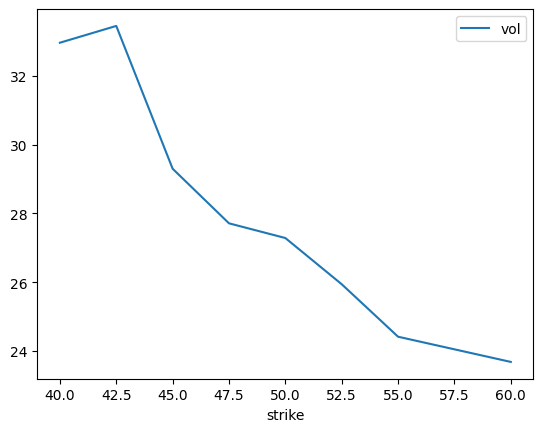

In [14]:
csco_opt_calls.plot(kind='line', x= "strike", y="vol")

In [12]:
#save to file
csco_opt_calls.to_excel("../data/csco_opt.xlsx", index=False)

## Incluir una parte sobre volatilidad histórica

In [18]:
days

210.0

In [23]:
(csco_hist['Close'].pct_change().std())*np.sqrt(csco_hist.shape[0])

0.5238589842303834

In [21]:
(csco_hist['Close'].rolling(int(days)).std()).mean()*np.sqrt(days)

3.95080393798521

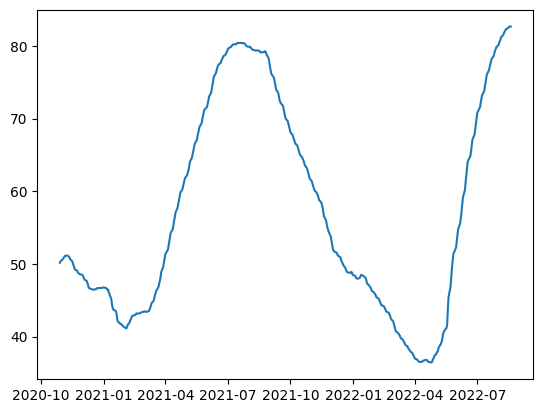

In [83]:
plt.plot(csco_hist['Close'].rolling(int(days)).std()*np.sqrt(days))

In [74]:
vol_df = pd.DataFrame()

vol_df["5"] = csco_hist['Close'].rolling(5).std()*np.sqrt(5)
vol_df["10"] = csco_hist['Close'].rolling(10).std()*np.sqrt(10)
vol_df["20"] = csco_hist['Close'].rolling(20).std()*np.sqrt(20)
vol_df["60"] = csco_hist['Close'].rolling(60).std()*np.sqrt(60)
vol_df["120"] = csco_hist['Close'].rolling(120).std()*np.sqrt(120)
vol_df["252"] = csco_hist['Close'].rolling(252).std()*np.sqrt(252)

<AxesSubplot:xlabel='Date'>

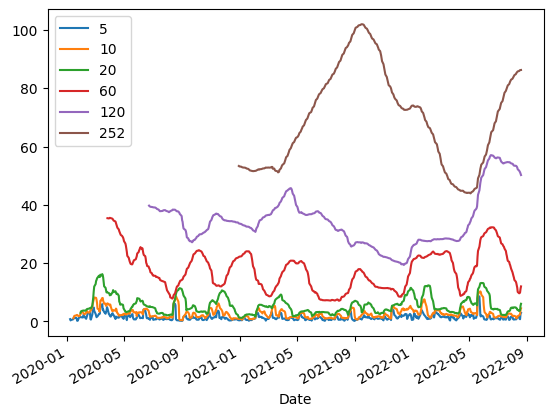

In [75]:
vol_df.plot()

In [58]:
vol_df["252"].max()

6.421917014837652